# Classify Wetland Vegetation with Random Forest Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Veggie-Forest.ipynb)

In [1]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    !pip install fiona --quiet --exists-action i
    !pip install shapely --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
else:
    path = '.'
    params = ''

In [2]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.patches import Patch, Rectangle
import fiona
import shapely
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
from skimage import segmentation, feature, future, morphology
from skimage.filters import rank
from skimage.color import rgb2lab
from sklearn.ensemble import RandomForestClassifier

In [3]:
"""Load RGB+NIR TIFF data"""
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()

# switch from band-first raster to band-last image to display later
img = np.moveaxis(src.read(), 0, 2)

## Make the input data for the classifier

The data we want to classify is our band-first RGB channels converted to L\*a\*b\* colorspace. 

In [4]:
"""Create a 3-band image in L*a*b* colorspace"""
lab = rgb2lab(rgb[:3,:,:], channel_axis=0)
print(lab.shape)

(3, 2117, 2950)


## Make single-band image with our training patches 

In [5]:
"""Set up categories to map"""
categories = {
    0: "undefined",
    1: "wetland 1",
    2: "wetland 2",
    3: "wetland 3",
    4: "wooded",
    5: "field",
    6: "aquatic vegetation",
    7: "open water",
    8: "roadway",
    9: "bare soil"}


In [6]:
"""Make training labels for use with geotiff"""
training_shapes = '{}/data/training-patches.fgb{}'.format(path, params)
training_labels = np.zeros(lab.shape[1:], dtype=np.uint8)       # band first (rasterio)
training_shape_patches = []

with fiona.open(training_shapes, 'r', driver='FlatGeoBuf') as training_src:
    for sample in training_src:
        label = sample['properties']['label']
        bbox = shapely.geometry.shape(sample.geometry).bounds
        window = from_bounds(*bbox, src.transform)
        training_labels[window.toslices()] = label
        training_shape_patches.append((int(label), Rectangle((window.col_off, window.row_off), window.width, window.height)))

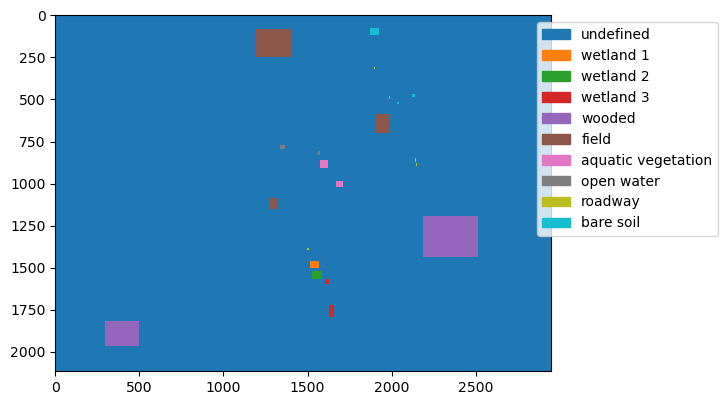

In [7]:
# Make a list of color patches for the legend
cmap = colormaps['tab10']    # tab10 is a ListedColormap
legend_patches = [Patch(color=cmap(category), label=label)
           for category, label in categories.items()]

"""Plot the training label raster"""
fig, ax = plt.subplots(1, 1)
ax.imshow(training_labels, cmap=cmap, interpolation='none')
ax.legend(handles=legend_patches, bbox_to_anchor=(1.35, 1), facecolor="white")
plt.show()

## Classify the data

This analysis follows the scikit-image documentation example:
[Trainable segmentation using local features and random forests](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html)

In [8]:
"""Make the classifier and predict"""
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=0)
features = features_func(lab)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)

result = future.predict_segmenter(features, clf)

## Plot the result

Let's see what it did...

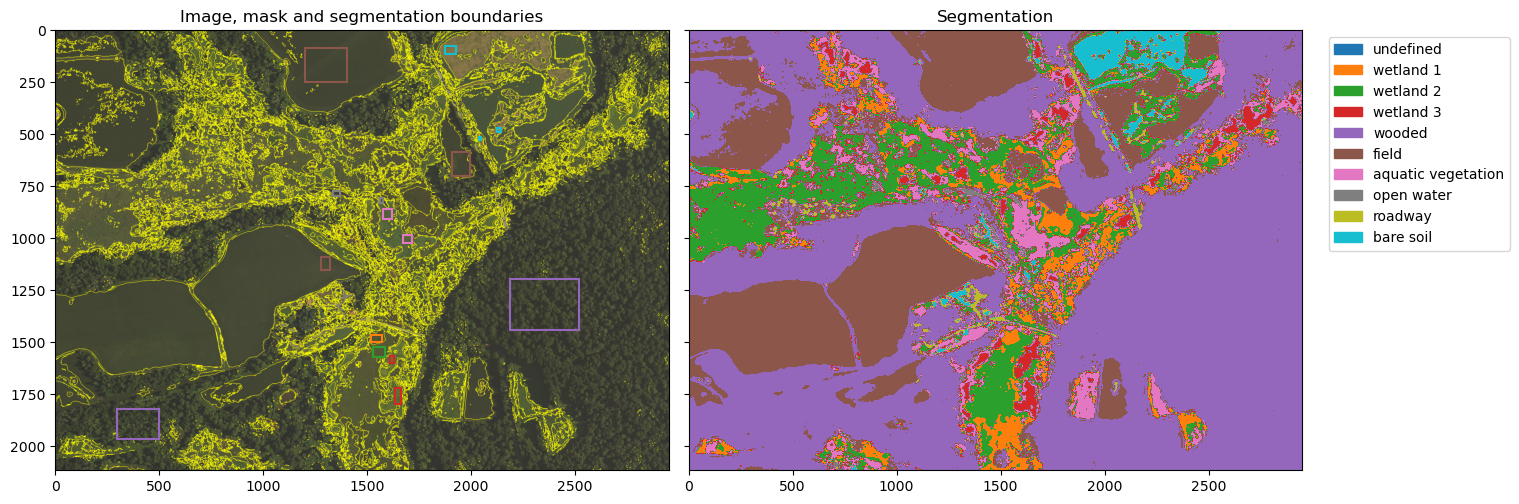

In [9]:
"""Plot the image and segmentation"""
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 8))
ax0.imshow(segmentation.mark_boundaries(img[:,:,:3], result, mode='thick'))
for label, rect in training_shape_patches:
    rect.set(edgecolor=cmap(label))
    rect.set(linewidth=1.5)
    rect.set(fill=False)
    ax0.add_artist(rect)
ax0.set_title('Image, mask and segmentation boundaries')

ax1.imshow(result, cmap=cmap, vmin=0, vmax=9, interpolation=None)
ax1.legend(handles=legend_patches, bbox_to_anchor=(1.35, 1), facecolor="white")
ax1.set_title('Segmentation')

fig.tight_layout()

plt.show()

The results of this analysis got a few things right: The wetland classes are where they should be except for a few fields that show up as aquatic vegetation. Shadows, however, are a problem and we see misclassifications on the shaded west side of isolated trees and treelines. We'll have to see what we can do about that.

## Write out the results

In [10]:
out_raster = './results/veg_classification.tif'
out_vector = './results/veg_classification.fgb'

""" Write out the classification result in raster format """
with rasterio.open(
    out_raster,
    'w',
    driver='GTiff',
    height=result.shape[0],
    width=result.shape[1],
    count=1,
    dtype=result.dtype,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(result, 1)


""" Write out the classification result as vectorized shapes """
schema = {
    'geometry': 'Polygon',
    'properties': {
        'id': 'int',
        'class': 'int'
    },
}

with fiona.open(out_vector, 'w', driver='FlatGeobuf', crs=src.crs, schema=schema) as dst:
    for idx, feature in enumerate(shapes(result, transform=src.transform)):
        geojson, value = feature
        dst.write({
            'geometry': shapely.geometry.shape(geojson),
            'properties': {
                'id': idx,
                'class': value
            }
        })

src.close()
